In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

import warnings
warnings.filterwarnings("ignore")
from imblearn.under_sampling import NearMiss
from collections import Counter

import random
from numpy.random import seed
import tensorflow as tf

In [2]:
# function to reset all RNG's to seed 23
def reset_random_seeds():
   tf.random.set_seed(23) # tensorflow's seed
   np.random.seed(23) # numpy's seed
   random.seed(23) # python's seed

# import data
data = pd.read_csv (r'bank-additional\bank-additional-full.csv', sep = ';', engine= 'python')
#data = data.head(1000)
length = data.shape[0]
data.head()

# select variables
cats_to_use = ['age', 'default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed', 'y']
data = data[cats_to_use]

# 'age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
#       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
#       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
#       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'

# save lists of categorical and numerical variables
cat_cols = ['default', 'contact', 'month', 'poutcome', 'y']
num_cols = ['age', 'previous', 'emp.var.rate', 'euribor3m', 'nr.employed']

# create column transformer to 1 one-hot-encode cat vars and 2 noralise num vars
ct = make_column_transformer(
    (OneHotEncoder(drop='first'), cat_cols), # drop first column (reference)
    (StandardScaler(), num_cols),
)

# transform base table (pandas df -> numpy array)
base = ct.fit_transform(data)

# convert base table to p.df for ease of use (numpy array -> pandas df)
base_temp = pd.DataFrame(base, columns=ct.get_feature_names_out().tolist())
base_temp

# seperate base table into X and y and convert to numpy array (base pandas df -> y numpy array + X numpy array)
y = base_temp['onehotencoder__y_yes'].values
X = base_temp.drop(columns=['onehotencoder__y_yes']).values

# save and check dimensions of X 
(X_length, X_vars) = X.shape
X_length, X_vars

# reset RNG's
reset_random_seeds()

# undersample data to get 50/50 success ratio using near-miss-1
undersample = NearMiss(version=1)
X, y = undersample.fit_resample(X, y)

(X_length, X_vars) = X.shape
X_length, X_vars

(9280, 19)

In [3]:
ss = StandardScaler()
X = ss.fit_transform(X)

# niet genormaliseerd
# X_train_ss = train_features
# X_test_ss = test_features
print(X.shape)

(9280, 19)


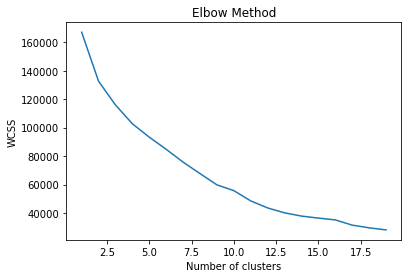

In [4]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [5]:
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X) # Compute cluster centers and predict cluster index for each sample
print(pred_y)

[1 1 1 ... 2 2 2]


In [6]:
Counter(pred_y)

Counter({1: 993,
         0: 602,
         5: 2099,
         3: 1317,
         2: 585,
         7: 303,
         4: 1883,
         8: 258,
         9: 315,
         6: 925})

In [7]:
cluster_dummies = pd.get_dummies(pred_y, drop_first = False)
print(X.shape)

Xnew = X.copy()
for x in cluster_dummies:
    Xnew = np.insert(Xnew, 19+x, cluster_dummies.iloc[:, x], axis=1)


Xnew = np.insert(Xnew, 29, y, axis=1)
print(Xnew)

(9280, 19)
[[ 3.57331023  0.          2.18019605 ...  0.          0.
   0.        ]
 [ 3.57331023  0.          2.18019605 ...  0.          0.
   0.        ]
 [ 3.57331023  0.          2.18019605 ...  0.          0.
   0.        ]
 ...
 [-0.27985256  0.         -0.45867435 ...  0.          0.
   1.        ]
 [-0.27985256  0.         -0.45867435 ...  0.          0.
   1.        ]
 [-0.27985256  0.         -0.45867435 ...  0.          0.
   1.        ]]


In [8]:
df = pd.DataFrame(Xnew)
print(df)

            0    1         2         3         4         5         6   \
0     3.573310  0.0  2.180196 -0.473917 -0.098404 -0.580834 -0.286953   
1     3.573310  0.0  2.180196 -0.473917 -0.098404 -0.580834 -0.286953   
2     3.573310  0.0  2.180196 -0.473917 -0.098404 -0.580834 -0.286953   
3    -0.279853  0.0  2.180196 -0.473917 -0.098404 -0.580834 -0.286953   
4     3.573310  0.0  2.180196 -0.473917 -0.098404 -0.580834 -0.286953   
...        ...  ...       ...       ...       ...       ...       ...   
9275 -0.279853  0.0 -0.458674 -0.473917 -0.098404 -0.580834 -0.286953   
9276 -0.279853  0.0 -0.458674 -0.473917 -0.098404 -0.580834 -0.286953   
9277 -0.279853  0.0 -0.458674 -0.473917 -0.098404 -0.580834 -0.286953   
9278 -0.279853  0.0 -0.458674 -0.473917 -0.098404 -0.580834 -0.286953   
9279 -0.279853  0.0 -0.458674 -0.473917 -0.098404 -0.580834 -0.286953   

           7         8         9   ...   20   21   22   23   24   25   26  \
0    -0.18372  1.902423 -0.287173  ...  1.0  0

In [9]:
df.to_csv(r'bank-additional\bank-additional-clusters.csv', index = False)